In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.utils.data as Data
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE

In [2]:
if(torch.cuda.is_available()):
    device = torch.device("cuda")
    print(device, torch.cuda.get_device_name(0))
else:
    device= torch.device("cpu")
    print(device)

cuda GeForce GTX 1660 SUPER


### Read training data to numpy array

In [45]:
fname = "body_acc_z_train.xlsx"  #the data file is located at the same directory
df=pd.read_excel(fname, header=None)

In [46]:
#convert data to numpy array
numpyX = np.array(df.values)
print(numpyX.shape)

(7352, 128)


### Define Auto-encoder

Reference: https://github.com/L1aoXingyu/pytorch-beginner/tree/master/08-AutoEncoder

In [5]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        
        self.encoder = nn.Sequential(   
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128, 64),                
            nn.Tanh(),
            nn.Linear(64, 64), 
            nn.Tanh(),
            nn.Linear(64, 32), 
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.Tanh(),
            nn.Linear(64, 64),                
            nn.Tanh(),
            nn.Linear(64, 128), 
            nn.Tanh(),
            nn.Linear(128, 128), 
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [6]:
model = autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

### Train NN

In [7]:
num_epochs = 1000
BATCH_SIZE = 512  #about 1/10 of training data

In [ ]:
train_lossLst = []
validation_lossLst = []

In [47]:
# split training data to train and validation
trainX, validationX = train_test_split(numpyX, test_size=0.20, random_state=0)

In [48]:
tensor_trainX = torch.FloatTensor(trainX).to(device)
tensor_validationX = torch.FloatTensor(validationX).to(device)

In [49]:
train_dataset = Data.TensorDataset(tensor_trainX)
train_loader = Data.DataLoader(
    dataset=train_dataset,  
    batch_size=BATCH_SIZE,      
    shuffle=True,       
    num_workers=0,   
)

In [50]:
for epoch in range(num_epochs):
    if(epoch%100 == 0):
      print(epoch, end=",")
    model.train().to(device)
    train_loss = 0
    epoch_lossLst=[]
    for batchX, in train_loader:
        batchX = batchX.to(device)
        output = model(batchX)
        loss = criterion(output, batchX)
        epoch_lossLst.append(float(loss))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    avg = sum(epoch_lossLst)/len(epoch_lossLst)
    train_lossLst.append(avg) 

    tensor_validationX_hat = model(tensor_validationX)
    validatiion_loss = criterion(tensor_validationX_hat, tensor_validationX)
    validation_lossLst.append(float(validatiion_loss))

0,100,200,300,400,500,600,700,800,900,

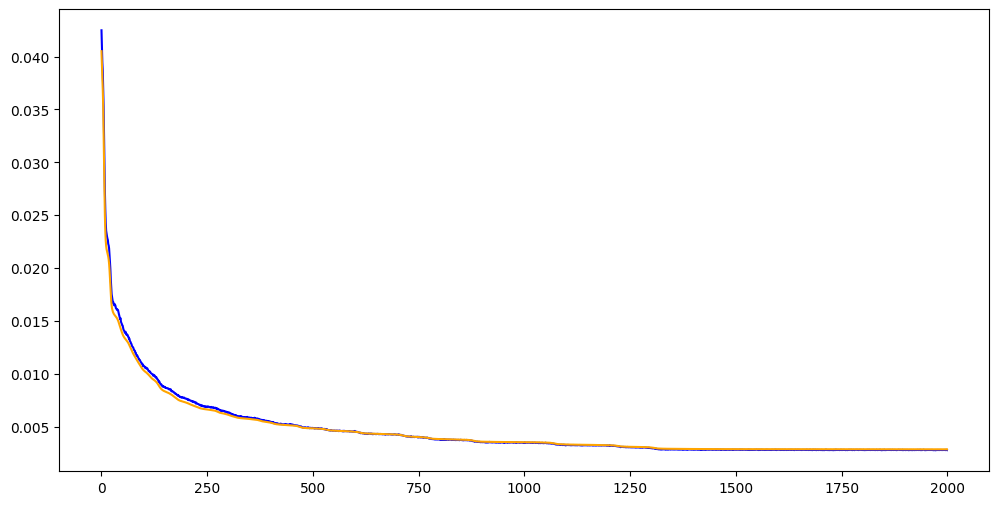

In [51]:
fig=plt.figure(figsize=(12, 6))
plt.plot(train_lossLst, color='blue')
plt.plot(validation_lossLst, color='orange')
plt.show()

### 練習: Visualize input/output of AE

Visualize input and output of training data

In [52]:
for batchX, in train_loader:
    break

In [53]:
batchX.shape

torch.Size([512, 128])

In [54]:
output = model(batchX.to(device))

In [55]:
output.shape

torch.Size([512, 128])

In [56]:
batchX = batchX.cpu().detach().numpy()
output = output.cpu().detach().numpy()

In [57]:
idx = 10  #take one data from batch, idx between 0 and batch size-1

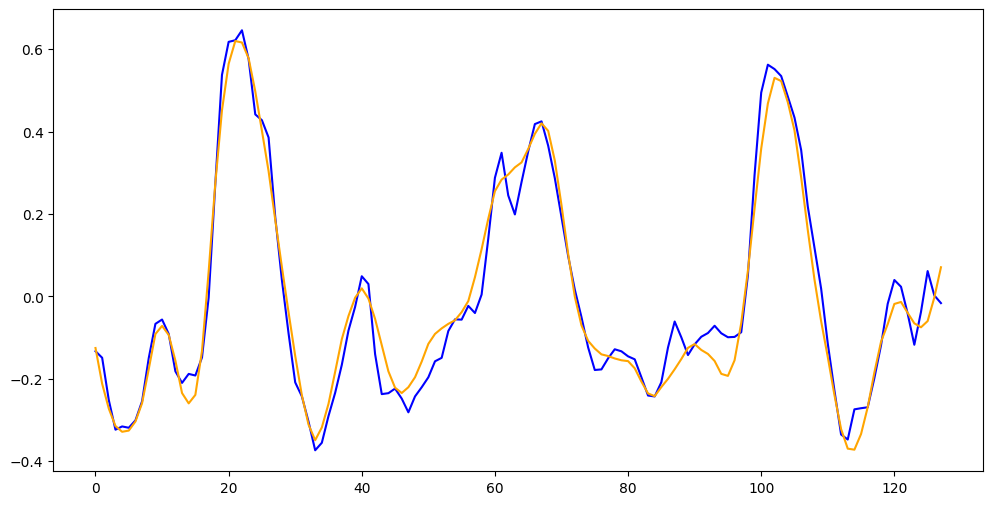

In [58]:
fig = plt.figure(figsize=(12, 6))
plt.plot(batchX[idx], color='blue')
plt.plot(output[idx], color='orange')
plt.show()

Visualize input and output using test data

In [59]:
fname = "body_acc_z_test.xlsx"  #the data file is located at the same directory
df=pd.read_excel(fname, header=None)

In [61]:
test_numpyX = np.array(df.values)
tensor_testX = torch.FloatTensor(test_numpyX)
test_dataset = Data.TensorDataset(tensor_testX)

In [62]:
test_loader = Data.DataLoader(
    dataset= test_dataset,     
    batch_size= 6,       
    shuffle=True,              
    num_workers=2,             
)

In [63]:
for batchX, in test_loader:
    break

In [64]:
batchX.shape

torch.Size([6, 128])

In [66]:
output = model(batchX.to(device))

In [67]:
output = output.cpu().detach().numpy()

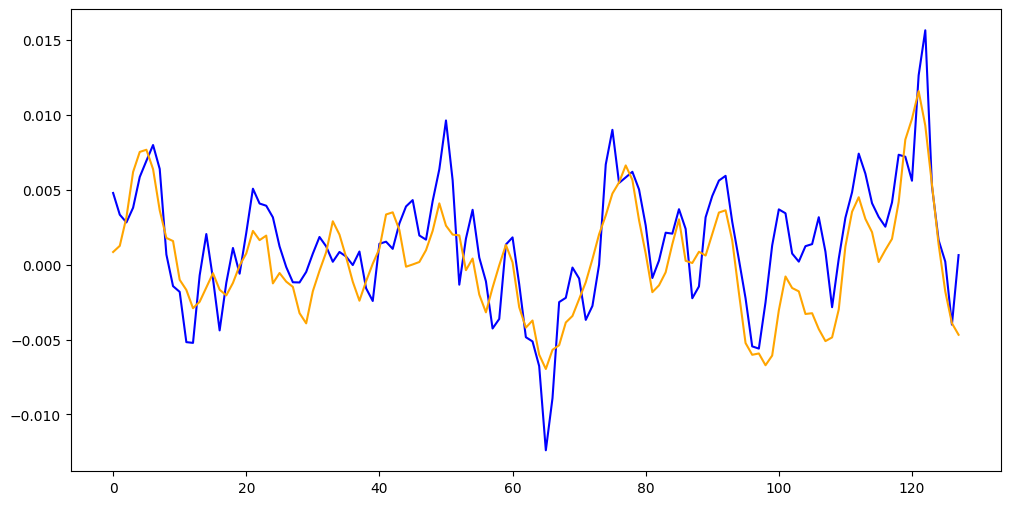

In [68]:
fig = plt.figure(figsize=(12, 6))
plt.plot(batchX[0], color='blue')
plt.plot(output[0], color='orange')
plt.show()

### 練習 Latent vectors

Get latent vector of training data

In [69]:
tensorX = torch.FloatTensor(numpyX).to(device)

In [70]:
lententVectors = model.encoder(tensorX.to(device))

In [71]:
lententVectors = lententVectors.cpu().detach().numpy()
print(lententVectors.shape)

(7352, 32)


Save latent vector to file

First we get the class lables of each training data

In [72]:
# get the class labels of the training data 
fname = "y_train.xlsx"  #the data file is located at the same directory
dfY=pd.read_excel(fname, header=None)
lstY = dfY.values.tolist()
print(len(lstY))

7352


In [73]:
len(lstY)

7352

In [74]:
lententVectors.shape[1]

32

In [75]:
headerLst = ['class']
for i in range(lententVectors.shape[1]):
    headerLst.append(i+1)
print(headerLst)

['class', 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]


In [76]:
result = []
for idx, elt in enumerate(dfY.values.tolist()):  
    row = [lstY[idx][0]]
    row = row + lententVectors[0].tolist()
    result.append(row)

In [77]:
df = pd.DataFrame(result, columns = headerLst)
df.to_csv("LatentVector_output.csv", index=False)

### Latent vectors + t-SNE clustering

練習: Use Orange tSNE to visualize the latent vector output file

練習: t-SNE using python

In [81]:
tsne = TSNE(perplexity=10, n_components=2, init='pca', n_iter=500)
result = tsne.fit_transform(lententVectors)

In [83]:
colors = ['blue', 'green', 'red', 'cyan', 'yellow', 'black', ]  # 6 activities
color_map = []
for elt in lstY: 
    idx = elt[0]-1
    color_map.append(colors[idx])

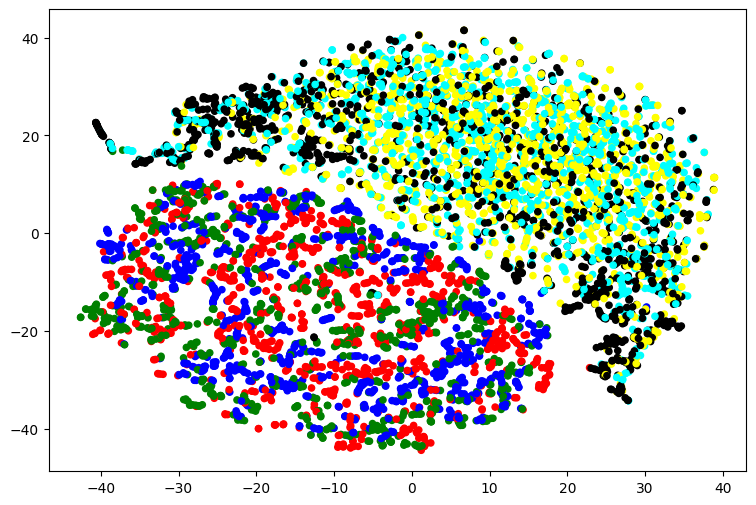

In [84]:
tSNEXarray = result[:, 0]
tSNEYarray = result[:, 1]
fig = plt.figure(figsize=(9, 6))
plt.scatter(tSNEXarray, tSNEYarray, color = color_map, s=20)
plt.show()

練習 Save clustering results to file

In [85]:
headerLst = ['class', 'x', 'y']
result = []
for idx, elt in enumerate(dfY.values.tolist()):  #1~6
    row = [elt[0], tSNEXarray[idx], tSNEYarray[idx]]
    result.append(row)

In [86]:
df = pd.DataFrame(result, columns = headerLst)
df.to_csv("tSNE_Results.csv", index=False)